In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]
import time


data_path = "../../../data_PHELPH/"
derrom_path = "../../"

import sys

# sys.path.append(derrom_path)
sys.path.insert(0,derrom_path)

import derrom
from derrom.utils import ivp_integrator
import PHELPH

In [2]:
kmax = 2.5
n_kmax = 100

tmax = 10000
n_tmax = 1001
dt = tmax/(n_tmax-1)
t_vec = np.linspace(0,tmax,n_tmax)

system = PHELPH.PHELPH(kmax=kmax, n_kmax=n_kmax)

v = 'v2'
system.g_photon = 0.04
system.tau_photon = 200
system.E_photon = 0.035
system.linewidth = 0.01

system.setup_laser()


In [3]:
el_scat_model = derrom.utils.load_model(data_path+'el_scat_model_self_con_I.obj')

def derivs(y):
    
    el_hist = y[:,:-1]
    el_state = y[-1,:-1]
    I = y[-1,-1]
    
    df = el_scat_model.predict(el_hist)
    df += -system.g_photon * I * system.lineshape_vec * (2.*el_state - 1.0)
    
    
    dI = -I/system.tau_photon + I * np.sum(system.I_gain_helper_vec * (2.*el_state - 1.0))
    dI += 1e-9
    
    return np.concatenate((df[0],[dI]))


integrator = derrom.utils.PHELPH_ivp_integrator(el_scat_model, derivs, dt=5.0, dt_out=10., method='Heun')

In [4]:
I_trajectories = derrom.utils.load_trajectories(filename=data_path + 'PHELPH_I_kmax2.5_nkmax_100_n1000_'+v+'.npz')
el_trajectories = derrom.utils.load_trajectories(filename=data_path + 'PHELPH_el_kmax2.5_nkmax_100_n1000_'+v+'.npz')
el_scattering = derrom.utils.load_trajectories(filename=data_path + 'PHELPH_el_scat_kmax2.5_nkmax_100_n1000_'+v+'.npz')

n_sample = 1

I_trajectories = I_trajectories[::n_sample]
el_trajectories = el_trajectories[::n_sample]
el_scattering = el_scattering[::n_sample]

n_trajectories = len(el_trajectories)
n_kmax = el_trajectories[0].shape[1]

trajectories = [ np.concatenate([el_trajectories[k],I_trajectories[k].reshape(-1,1)], axis=1) for k in range(n_trajectories) ]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)

mean_I_max = np.mean([I.max() for I in I_trajectories])
# print(mean_I_max)
mean_I_area = np.mean([np.sum(I) for I in I_trajectories])
# print(mean_I_area)
mean_I_max_pos = np.mean([np.argmax(I)*dt for I in I_trajectories])
# print(mean_I_max_pos)

median_I_max = np.median([I.max() for I in I_trajectories])
median_I_max_pos = np.median([np.argmax(I)*dt for I in I_trajectories])

cutoff = int(n_trajectories*0.9)

train_I_trajectories = I_trajectories[:cutoff]
train_el_trajectories = el_trajectories[:cutoff]
train_el_scattering = el_scattering[:cutoff]

test_I_trajectories = I_trajectories[cutoff:]
test_el_trajectories = el_trajectories[cutoff:]
test_el_scattering = el_scattering[cutoff:]

test_trajectories = trajectories[cutoff:]

1000 loaded with n_kmax = 100


In [5]:
ind = 3

test_el_trajectory = test_el_trajectories[ind]
test_I_trajectory = test_I_trajectories[ind]
test_trajectory = test_trajectories[ind]


ttrt_inits = np.concatenate([test_trajectory[0,:system.n_kmax],[system.T_cryo],[test_trajectory[0,-1]]])
ttrt_approx = system.two_temperature_rel_time_approx(ttrt_inits,tmax=tmax, n_tmax=n_tmax,tau_rel=500,tau_Tp=4000)

/Users/Stefan/Code/data_driven_projects/derrom/examples/PHELPH/../ELPH/fermi_fit.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return 1./(np.exp((E-mu)/(self.kB*T)) + 1)
/Users/Stefan/Code/data_driven_projects/derrom/examples/PHELPH/../ELPH/fermi_fit.py:31: RuntimeWarning: overflow encountered in exp
  return 1./(np.exp((E-mu)/(self.kB*T)) + 1)
/Users/Stefan/Code/data_driven_projects/derrom/examples/PHELPH/../ELPH/fermi_fit.py:124: RuntimeWarning: invalid value encountered in scalar divide
  mstep = (deltaE*dDdT-deltaD*dEdT)/Jacobi_Det
/Users/Stefan/Code/data_driven_projects/derrom/examples/PHELPH/../ELPH/fermi_fit.py:125: RuntimeWarning: invalid value encountered in scalar divide
  Tstep = (deltaD*dEdmu-deltaE*dDdmu)/Jacobi_Det


In [6]:
import fermi_fit
fermi_fitter = fermi_fit.fermi_fit(system.DOS_vec, system.E_el_vec, system.kB)

Te_vec = []
mus = []
Steps = []

ind_start = 0

for k in range(ttrt_approx[ind_start:,:-2].shape[0]):
    mu,Temp,steps = fermi_fitter.fit_mu_T(ttrt_approx[ind_start:,:-2][k], 0.1, 300, False)
    mus.append(mu)
    Te_vec.append(Temp)
    Steps.append(steps)

Te_vec = np.asarray(Te_vec)

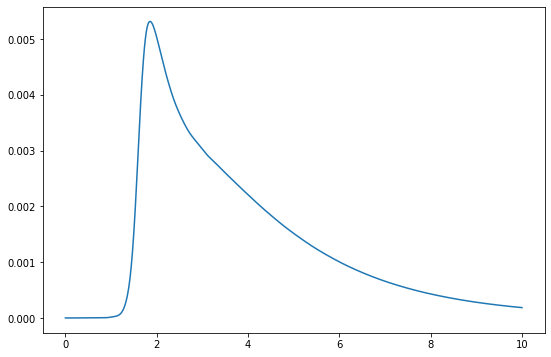

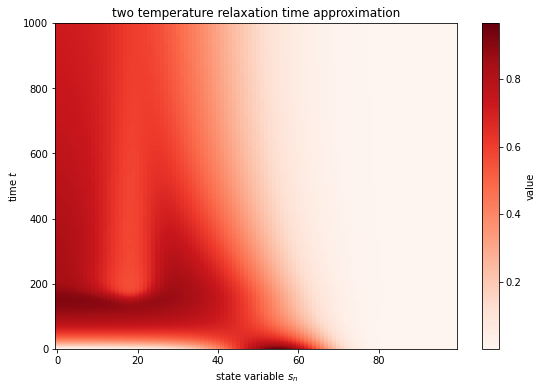

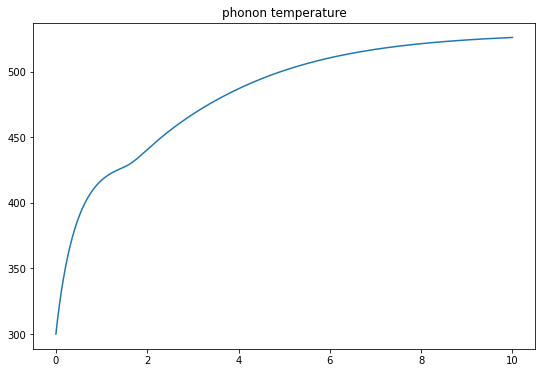

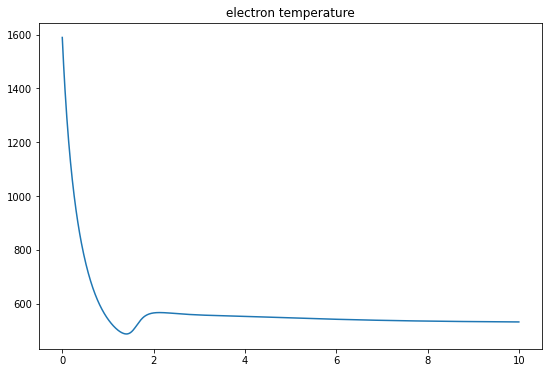

In [7]:
plt.plot(t_vec/1000,ttrt_approx[:,-1],label='two_temperature rel time approx')
plt.show()

derrom.utils.plot_trajectory(ttrt_approx[:,:-2],title='two temperature relaxation time approximation')
plt.show()


plt.plot(t_vec/1000,ttrt_approx[:,-2],label='two_temperature rel time approx')
plt.title("phonon temperature")
plt.show()


plt.plot(t_vec/1000,Te_vec)
plt.title("electron temperature")
plt.show()

In [ ]:
mean_I_max = np.mean([I.max() for I in I_trajectories])
# print(mean_I_max)
mean_I_area = np.mean([np.sum(I) for I in I_trajectories])
# print(mean_I_area)

ttrta_scores = []

t_start = time.time()
for trajectory in trajectories[:20]:
    
    ttrt_inits = np.concatenate([trajectory[0,:system.n_kmax],[system.T_cryo],[trajectory[0,-1]]])
    ttrt_approx = system.two_temperature_rel_time_approx(ttrt_inits,tmax=tmax, n_tmax=n_tmax,tau_rel=500,tau_Tp=4000)
    
    ttrt_approx = np.concatenate([ttrt_approx[:,:-2],ttrt_approx[:,-1:]],axis=1) #remove phonon temperature variable
    
    el_rms = integrator.get_error(trajectory,pred=ttrt_approx, norm='rms')
    el_max = integrator.get_error(trajectory,ttrt_approx, norm='max')
    I_max = integrator.get_error(trajectory,ttrt_approx, norm='I_max')
    I_max_pos = integrator.get_error(trajectory,ttrt_approx, norm='I_max_pos')
    I_area = integrator.get_error(trajectory,ttrt_approx, norm='I_area')
    
    ttrta_scores.append([el_rms,el_max,I_max,I_max_pos,I_area])

t_end = time.time()
print("computation time:", t_end - t_start)
    
ttrta_scores = np.array(ttrta_scores).T
print(ttrta_scores.shape)

In [14]:
np.savetxt(data_path+'PHELPH_TTRTA_scores', ttrta_scores)

In [3]:
ttrta_scores=np.loadtxt(data_path+'PHELPH_TTRTA_scores')

rms error:  0.06910418527965632 +- 0.018612190184905533
max error:  0.2740492511217708 +- 0.07959308288024454
I_max error:  0.6065157486626509 +- 0.2510552666736548
I_max_pos error:  507.31 +- 750.8335793636296
I_area error:  0.16635941702227372 +- 0.05307292448628508
0.6086459842408231
0.6132738551725695
pulse sum score:  1.2219198394133926
pulse mult score:  0.37326666919067253
combined mult score:  0.03274159930313544
90th percentile I_max err 0.9591345066718254
90th percentile I_max_pos err 0.42487046632124353


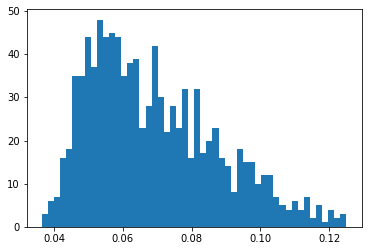

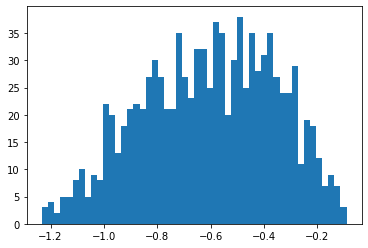

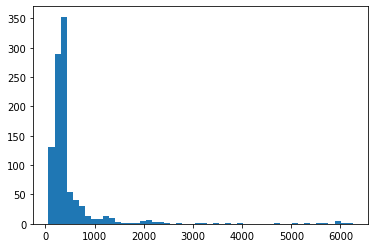

In [40]:
print('rms error: ', str(np.mean(ttrta_scores[0])) + ' +- ' + str(np.std(ttrta_scores[0])) )
print('max error: ', str(np.mean(ttrta_scores[1])) + ' +- ' + str(np.std(ttrta_scores[1])) )
print('I_max error: ', str(np.mean(np.abs(ttrta_scores[2]))/mean_I_max) + ' +- ' + str(np.std(np.abs(ttrta_scores[2]))/mean_I_max) )
print('I_max_pos error: ', str(np.mean(np.abs(ttrta_scores[3]))) + ' +- ' + str(np.std(np.abs(ttrta_scores[3]))) )
print('I_area error: ', str(np.mean(np.abs(ttrta_scores[4]))/mean_I_area) + ' +- ' + str(np.std(np.abs(ttrta_scores[4]))/mean_I_area) )


el_rms_score = np.mean(ttrta_scores[0]) + np.std(ttrta_scores[0])
I_max_score = np.mean(np.abs(ttrta_scores[2]))/mean_I_max + np.std(np.abs(ttrta_scores[2]))
I_max_pos_score = np.mean(np.abs(ttrta_scores[3])) + np.std(np.abs(ttrta_scores[3]))
I_max_pos_score /= mean_I_max_pos
print(I_max_score)
print(I_max_pos_score)
print('pulse sum score: ', I_max_score + I_max_pos_score)
print('pulse mult score: ', I_max_score * I_max_pos_score)
print('combined mult score: ', I_max_score * I_max_pos_score * el_rms_score)

print('90th percentile I_max err', np.percentile(np.abs(ttrta_scores[2]),90) / median_I_max )
print('90th percentile I_max_pos err', np.percentile(np.abs(ttrta_scores[3]),90) / median_I_max_pos )


nBins = 50

plt.hist(ttrta_scores[0], bins=nBins)
plt.show()

# plt.hist(ttrta_scores[1], bins=nBins)
# plt.show()

plt.hist(ttrta_scores[2]/mean_I_max, bins=nBins)
plt.show()

plt.hist(ttrta_scores[3], bins=nBins)
plt.show()

# plt.hist(ttrta_scores[4]/mean_I_area, bins=nBins)
# plt.show()

## Simple relaxation time approximation

...with constant lattice temperature

In [15]:
rel_time_approx = system.rel_time_approx(test_trajectory[0].flatten(),tmax=tmax, n_tmax=n_tmax,tau_rel=1000)


print('rms error:', integrator.get_error(test_trajectory,rel_time_approx, norm='rms'))
print('max error:', integrator.get_error(test_trajectory,rel_time_approx, norm='max'))
print('I_max error:', integrator.get_error(test_trajectory,rel_time_approx, norm='I_max'))
print('I_max_pos error:', integrator.get_error(test_trajectory,rel_time_approx, norm='I_max_pos'))
print('I_area error:', integrator.get_error(test_trajectory,rel_time_approx, norm='I_area'))

rms error: 0.1690603266738945
max error: 0.49527647793998625
I_max error: -0.009286758182124292
I_max_pos error: 900.0
I_area error: -0.030137661447420028


In [ ]:
rta_scores = []

for trajectory in trajectories:
    rel_time_approx = system.rel_time_approx(trajectory[0].flatten(),tmax=tmax, n_tmax=n_tmax,tau_rel=1000)
    
    el_rms = integrator.get_error(trajectory,rel_time_approx, norm='rms')
    el_max = integrator.get_error(trajectory,rel_time_approx, norm='max')
    I_max = integrator.get_error(trajectory,rel_time_approx, norm='I_max')
    I_max_pos = integrator.get_error(trajectory,rel_time_approx, norm='I_max_pos')
    I_area = integrator.get_error(trajectory,rel_time_approx, norm='I_area')
    
    rta_scores.append([el_rms,el_max,I_max,I_max_pos,I_area])